Load Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb 
import re
import joblib 

# --- Step 1: Data Loading and Preprocessing ---


In [2]:

print("\n--- Step 1: Data Loading and Preprocessing ---")

# Load the dataset
dataset_path = 'incidents.csv' # Ensure this file exists in your directory
df = None 

try:
    df = pd.read_csv(dataset_path)
    print(f"Dataset '{dataset_path}' loaded successfully.")
    print(f"Initial shape of the dataset: {df.shape}")
    
    # --- Data Cleaning ---
    print("\n--- Data Cleaning ---")

    # Define column types 
    numeric_cols = ['Customer Score'] 
    categorical_cols = ['Category', 'Priority', 'Assignment Group', 'Assignee'] 
    datetime_cols = ['Start Time', 'End Time'] 
    text_cols = ['Issue Description', 'Work Notes', 'Resolution Notes'] 

    # Impute numerical columns 
    for col in numeric_cols:
        if col in df.columns and df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)

    # Impute categorical columns 
    for col in categorical_cols:
        if col in df.columns and df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)

    # Handle missing text data 
    for col in text_cols:
        if col in df.columns:
            df[col].fillna('', inplace=True)
            

    # Convert data types - FIX: Do datetime conversion BEFORE string operations
    for col in datetime_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            print(f"Converted {col} to datetime: {df[col].dtype}")

    if 'Customer Score' in df.columns and df['Customer Score'].dtype == 'object':
        df['Customer Score'] = pd.to_numeric(df['Customer Score'], errors='coerce')

    # Standardize categorical columns - EXCLUDE datetime columns from string operations
    categorical_cols_to_standardize = [col for col in df.select_dtypes(include='object').columns 
                                       if col not in datetime_cols]
    for col in categorical_cols_to_standardize:
        df[col] = df[col].str.strip().str.lower()

    # Remove Duplicates
    df.drop_duplicates(inplace=True)

    # --- Feature Engineering: Calculate Target Variables ---
    print("\n--- Feature Engineering: Calculate Target Variables ---")
    
    # FIX: Corrected syntax error in 'if' condition below
    if 'Start Time' in df.columns and 'End Time' in df.columns and \
       pd.api.types.is_datetime64_any_dtype(df['Start Time']) and pd.api.types.is_datetime64_any_dtype(df['End Time']):
        
        df['resolution_time_minutes'] = (df['End Time'] - df['Start Time']).dt.total_seconds() / 60
        
        # Handle negative resolution times
        df.loc[df['resolution_time_minutes'] < 0, 'resolution_time_minutes'] = np.nan
    else:
        print("Error: Datetime columns not ready.")

    # --- Create Train-Test Splits ---
    print("\n--- Creating Train-Test Splits ---")

    TARGET_RESOLUTION = 'resolution_time_minutes'
    
    # Drop identifying columns and timestamps
    cols_to_drop = ['INC Number', 'Issue Description', 'Work Notes', 'Resolution Notes', 'Customer Review', 'Start Time', 'End Time']
    df_for_split = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # Ensure categorical columns are strings
    for col in df_for_split.select_dtypes(include='object').columns:
        df_for_split[col] = df_for_split[col].astype(str)

    # Drop rows where target is NaN
    df_for_split = df_for_split.dropna(subset=[TARGET_RESOLUTION])

    X_full = df_for_split.drop(columns=[TARGET_RESOLUTION])
    y_resolution = df_for_split[TARGET_RESOLUTION]

    # Split data
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_full, y_resolution, test_size=0.2, random_state=42)
    print(f"Train set shape: {X_train_res.shape}")
    print(f"Test set shape: {X_test_res.shape}")

    # --- Preprocessing Pipeline Setup --- 
    numerical_features = X_train_res.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X_train_res.select_dtypes(include='object').columns.tolist()
    text_features = [f for f in text_cols if f in X_train_res.columns]

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features),
            ('text', text_transformer, text_features)
        ],
        remainder='passthrough'
    )
    print("Preprocessing pipeline defined.")

except FileNotFoundError:
    print(f"Error: File {dataset_path} not found. Please upload the dataset.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Step 1: Data Loading and Preprocessing ---
Dataset 'incidents.csv' loaded successfully.
Initial shape of the dataset: (100, 12)

--- Data Cleaning ---
Converted Start Time to datetime: datetime64[ns]
Converted End Time to datetime: datetime64[ns]

--- Feature Engineering: Calculate Target Variables ---

--- Creating Train-Test Splits ---
Train set shape: (80, 5)
Test set shape: (20, 5)
Preprocessing pipeline defined.


C:\Users\ajsty\AppData\Local\Temp\ipykernel_42304\1747602365.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('', inplace=True)


In [3]:
print("Available columns:")
print(df.columns.tolist())
print("\nChecking for resolution_time_minutes:", 'resolution_time_minutes' in df.columns)
print("\nDataFrame info:")
print(df.info())

Available columns:
['INC Number', 'Issue Description', 'Category', 'Priority', 'Work Notes', 'Resolution Notes', 'Start Time', 'End Time', 'Assignment Group', 'Assignee', 'Customer Score', 'Customer Review', 'resolution_time_minutes']

Checking for resolution_time_minutes: True

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   INC Number               100 non-null    object        
 1   Issue Description        100 non-null    object        
 2   Category                 100 non-null    object        
 3   Priority                 100 non-null    object        
 4   Work Notes               100 non-null    object        
 5   Resolution Notes         100 non-null    object        
 6   Start Time               100 non-null    datetime64[ns]
 7   End Time                 100 non-null    datet

--- EDA Section ---
Available columns:
['INC Number', 'Issue Description', 'Category', 'Priority', 'Work Notes', 'Resolution Notes', 'Start Time', 'End Time', 'Assignment Group', 'Assignee', 'Customer Score', 'Customer Review', 'resolution_time_minutes']

DataFrame shape: (100, 13)


C:\Users\ajsty\AppData\Local\Temp\ipykernel_42304\2319348328.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='resolution_time_hours', data=df, errorbar=None, palette='viridis')
C:\Users\ajsty\AppData\Local\Temp\ipykernel_42304\2319348328.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Priority', y='resolution_time_hours', data=df, errorbar=None, palette='magma')
C:\Users\ajsty\AppData\Local\Temp\ipykernel_42304\2319348328.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Customer Score', y='resolution_time_

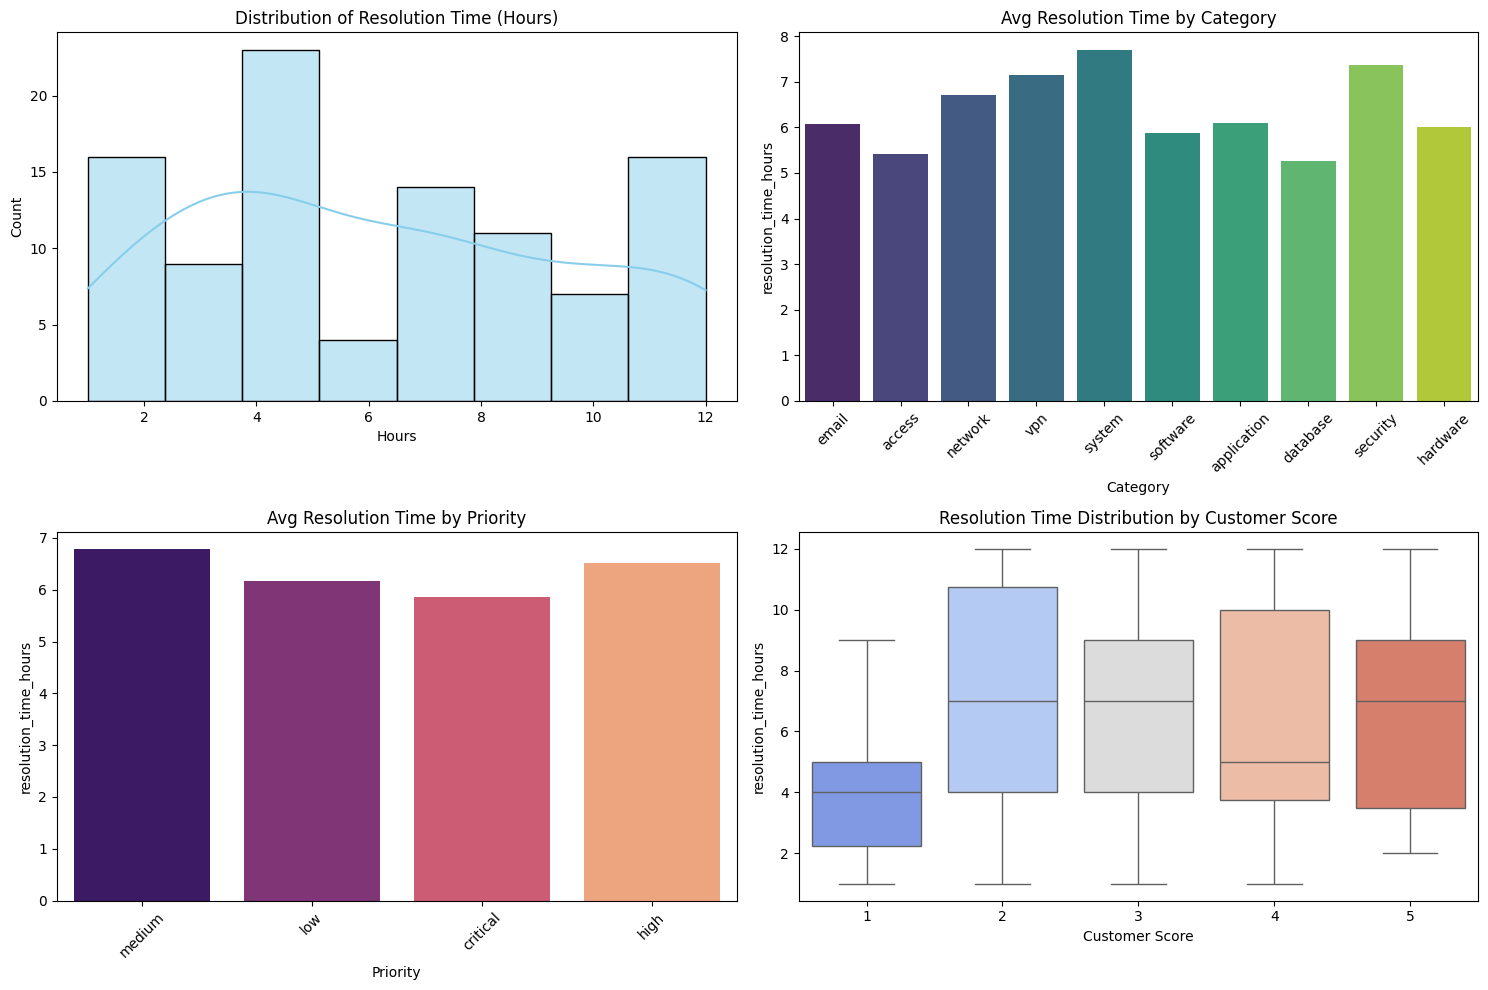

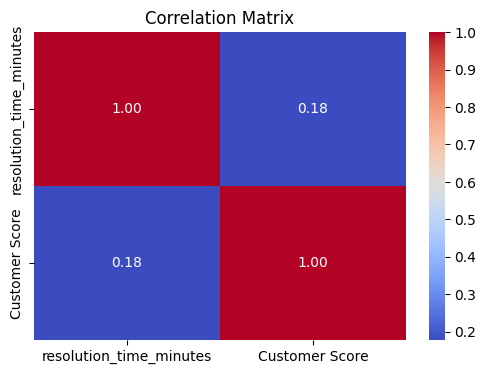

In [4]:
print("--- EDA Section ---")

# First, check what columns exist in your dataframe
print("Available columns:")
print(df.columns.tolist())
print("\nDataFrame shape:", df.shape)

# Create the plots using the correct column names from YOUR dataset
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of Resolution Time (converted to hours)
plt.subplot(2, 2, 1)
df['resolution_time_hours'] = df['resolution_time_minutes'] / 60
sns.histplot(df['resolution_time_hours'], kde=True, color='skyblue')
plt.title('Distribution of Resolution Time (Hours)')
plt.xlabel('Hours')

# Plot 2: Average Resolution Time by Category
plt.subplot(2, 2, 2)
sns.barplot(x='Category', y='resolution_time_hours', data=df, errorbar=None, palette='viridis')
plt.title('Avg Resolution Time by Category')
plt.xticks(rotation=45)

# Plot 3: Average Resolution Time by Priority
plt.subplot(2, 2, 3)
sns.barplot(x='Priority', y='resolution_time_hours', data=df, errorbar=None, palette='magma')
plt.title('Avg Resolution Time by Priority')
plt.xticks(rotation=45)

# Plot 4: Resolution Time vs Customer Score
plt.subplot(2, 2, 4)
sns.boxplot(x='Customer Score', y='resolution_time_hours', data=df, palette='coolwarm')
plt.title('Resolution Time Distribution by Customer Score')

plt.tight_layout()
plt.show()

# Correlation Heatmap for numeric features
plt.figure(figsize=(6, 4))
# Use only numeric columns that actually exist in your dataset
numeric_cols = ['resolution_time_minutes', 'Customer Score']
# Add any other numeric columns that exist in your incidents.csv
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
print("\n--- Step 3: Feature Selection, Preprocessing, and Model Training ---")

# Ensure target exists
if 'resolution_time_hours' not in df.columns:
    print("Creating resolution_time_hours column...")
    if 'resolution_time_minutes' in df.columns:
        df['resolution_time_hours'] = df['resolution_time_minutes'] / 60
    else:
        raise KeyError("Neither resolution_time_hours nor resolution_time_minutes found in DataFrame")

# Base structured features
base_feature_cols = ['Category', 'Priority', 'Assignment Group', 'Customer Score']

# Text features (optional, if present)
text_feature_cols = []
for tcol in ['Issue Description', 'Work Notes']:
    if tcol in df.columns:
        text_feature_cols.append(tcol)

# Build final feature list
feature_cols = base_feature_cols + text_feature_cols

# Prepare X, y
X = df[feature_cols].copy()
y = df['resolution_time_hours'].copy()

# Remove any rows where target is NaN
mask = ~y.isna()
X = X[mask]
y = y[mask]

# Simple sanity prints
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types within current X
numeric_cols = [c for c in X_train.columns if c == 'Customer Score']
categorical_cols = [c for c in ['Category', 'Priority', 'Assignment Group'] if c in X_train.columns]
text_cols_in_use = [c for c in text_feature_cols if c in X_train.columns]

# Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use separate TF-IDF vectorizer per text column to preserve feature names
# Note: ColumnTransformer will apply vectorizer to each column's raw text
text_transformers = []
for tcol in text_cols_in_use:
    text_transformers.append((
        f'text_{tcol.replace(" ", "_").lower()}', 
        TfidfVectorizer(stop_words='english', max_features=1000), 
        tcol
    ))

# Build ColumnTransformer
transformers = []
if numeric_cols:
    transformers.append(('num', numerical_transformer, numeric_cols))
if categorical_cols:
    transformers.append(('cat', categorical_transformer, categorical_cols))
transformers.extend(text_transformers)

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop'
)
print("Preprocessing pipeline configured.")

# Create model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# Train
print("\nTraining Model...")
model_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = model_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"MAE: {mae:.2f} Hours")
print(f"R2 Score: {r2:.2f}")

# Save the full pipeline (includes preprocessing and model)
joblib.dump(model_pipeline, 'incident_resolution_pipeline.pkl')
print("Model pipeline saved (incident_resolution_pipeline.pkl).")


--- Step 3: Feature Selection, Preprocessing, and Model Training ---
Features shape: (100, 6)
Target shape: (100,)

Feature columns: ['Category', 'Priority', 'Assignment Group', 'Customer Score', 'Issue Description', 'Work Notes']
Preprocessing pipeline configured.

Training Model...
Model Performance:
MAE: 2.29 Hours
R2 Score: -0.12
Model pipeline saved (incident_resolution_pipeline.pkl).
Model pipeline saved (incident_resolution_pipeline.pkl).


\n--- Step 3 (New): Train with Text Features ---
Using feature columns: ['Category', 'Priority', 'Assignment Group', 'Customer Score', 'Issue Description', 'Work Notes']
Features shape: (100, 6); Target shape: (100,)
{'numeric': ['Customer Score'], 'categorical': ['Category', 'Priority', 'Assignment Group'], 'text': ['Issue Description', 'Work Notes']}
Preprocessing configured.
Training model...
MAE: 2.28 hours
R2: -0.096
Saved pipeline to incident_resolution_pipeline.pkl
